# Exercise 3. Regularization

In this exercise, we will try a few methods to prevent overfitting of an MLP network to training data.

## Learning goals:
* Understand various methods to prevent overfitting of neural networks.
* Experience in using regularization methods in pytorch.

In [48]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.optim.lr_scheduler import StepLR

In [4]:
# Select device which you are going to use for training
device = torch.device("cpu")

In [5]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Regression problem
We will look at a regression problem where the task is to estimate a function of one variable
$$y = f(x)$$
using a set of training examples $(x_1, y_1), \ldots, (x_n, y_n)$.

Let us first generate training examples $y_i=\sin(x_i) + n_i$ with $x_i$ drawn from the uniform distribution in $[-0.5, 0.5]$ and noise $n_i$ drawn from the Gaussian distribution.

In [6]:
np.random.seed(0)
n = 80
x = np.random.rand(n, 1)-0.5

def fun(x):
    y = np.cos(2* np.pi * x)
    y += 0.3 * np.random.randn(*x.shape)
    return y

y = fun(x)

Let us split the data into training, validation and test sets and plot the training and validation sets. And let us plot the data.

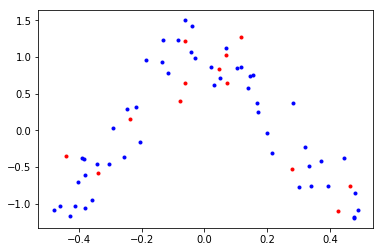

In [7]:
# Let us split the data into training, validation and test sets and plot the training and validation sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1, shuffle=True)

#  And let us plot the data
fix, ax = plt.subplots(1)
ax.plot(x_train, y_train, 'b.')
ax.plot(x_val, y_val, 'r.')

## Define a multi-layer perceptron (MLP) network with two hidden layers

In the code below, we define a neural network architecture with:
* input dimension 1
* one hidden layer with 100 units with tanh nonlinearity
* one hidden layer with 100 units with tanh nonlinearity
* linear output layer with output dimension 1

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1))

    def forward(self, x):
        return self.net(x)

In [9]:
# Let us create an MLP network
mlp = MLP()
mlp.to(device)

MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [10]:
# This visualizes the function implemented by an MLP
def plot_fit(mlp, x_train, y_train):
    fig, ax = plt.subplots(1)
    ax.plot(x_train, y_train, '.')
    x_np = np.linspace(-0.5, 0.5, 100).reshape((-1, 1))
    x = torch.tensor(x_np, device=device, dtype=torch.float)
    pred = mlp.forward(x).cpu().data.numpy()
    ax.plot(x_np, pred)

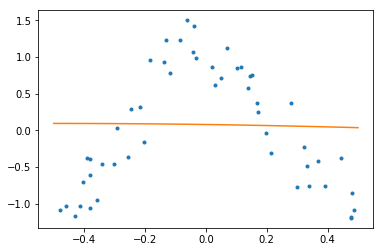

In [11]:
# Plot the function implemented by the MLP
plot_fit(mlp, x_train, y_train)

In [12]:
# This is the function to compute the loss:
def compute_loss(mlp, x, y):
    mlp.eval()
    with torch.no_grad():
        x = torch.tensor(x, device=device, dtype=torch.float)
        y = torch.tensor(y, device=device, dtype=torch.float)
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        return np.asscalar(loss.cpu().data.numpy())

# This is the function to print the progress during training
def print_progress(epoch, train_error, val_error):
    print('Train Epoch {}: Train error {:.2f} Validation error {:.2f}'.format(
        epoch, train_error, val_error))

## Train the MLP network without regularization
Training is done by minimizing the mean-squared error computed on the training data:
$$c=\sum_{i=1}^n || f(x_i) - y_i ||^2.$$

Here, we train the network:
* using all the data for computing the gradient (batch mode)
* using `n_epochs` epochs (which is equal to the number of parameter updates in the batch mode).

In [13]:
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
n_epochs = 10000
train_errors = []  # Keep track of the training data
val_errors = []  # Keep track of the validation data
for epoch in range(n_epochs):
    x = torch.tensor(x_train, device=device, dtype=torch.float)
    y = torch.tensor(y_train, device=device, dtype=torch.float)

    optimizer.zero_grad()
    outputs = mlp.forward(x)
    loss = F.mse_loss(outputs, y)
    loss.backward()
    optimizer.step()

    if (epoch % 500) == 0:
        train_errors.append(compute_loss(mlp, x_train, y_train))
        val_errors.append(compute_loss(mlp, x_val, y_val))
        print_progress(epoch, train_errors[-1], val_errors[-1])

Train Epoch 0: Train error 0.66 Validation error 0.62
Train Epoch 500: Train error 0.07 Validation error 0.15
Train Epoch 1000: Train error 0.07 Validation error 0.15
Train Epoch 1500: Train error 0.07 Validation error 0.16
Train Epoch 2000: Train error 0.06 Validation error 0.16
Train Epoch 2500: Train error 0.06 Validation error 0.18
Train Epoch 3000: Train error 0.05 Validation error 0.20
Train Epoch 3500: Train error 0.04 Validation error 0.24
Train Epoch 4000: Train error 0.03 Validation error 0.30
Train Epoch 4500: Train error 0.03 Validation error 0.32
Train Epoch 5000: Train error 0.03 Validation error 0.33
Train Epoch 5500: Train error 0.02 Validation error 0.35
Train Epoch 6000: Train error 0.01 Validation error 0.38
Train Epoch 6500: Train error 0.01 Validation error 0.39
Train Epoch 7000: Train error 0.01 Validation error 0.40
Train Epoch 7500: Train error 0.01 Validation error 0.40
Train Epoch 8000: Train error 0.01 Validation error 0.41
Train Epoch 8500: Train error 0.01 

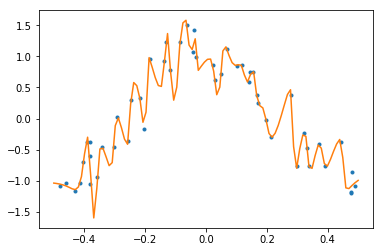

In [14]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [15]:
# Let's look at the test loss
test_loss_no_regularization = compute_loss(mlp, x_test, y_test)
print("Test loss without regularization: %.5f" % test_loss_no_regularization)

Test loss without regularization: 0.23199


As you can see, the network overfits to the training data.

# Early stopping

One of the simplest ways to avoid overfitting is to stop training when the validation error starts to grow.

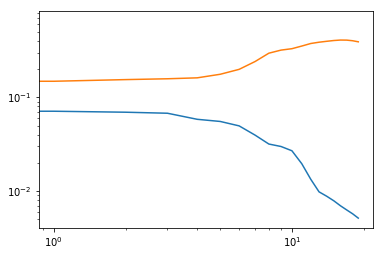

In [16]:
# Let us look at the learning curves: the evolution of training and validation errors during training
fig, ax = plt.subplots(1)
ax.loglog(train_errors)
ax.loglog(val_errors)

In the code below, define a stopping creterion in function `stop_criterion`. Training should be stopped (function returns  `True`) when the validation error is larger than the best validation error obtained so far (with given `tolearance`) for `patience` epochs.

In [17]:
class EarlyStopping:
    def __init__(self, tolerance, patience):
        """
        Args:
          patience (int):    Maximum number of epochs with unsuccessful updates.
          tolerance (float): We assume that the update is unsuccessful if the validation error is larger
                              than the best validation error so far plus this tolerance.
        """
        self.tolerance = tolerance
        self.patience = patience
    
    def stop_criterion(self, val_errors):
        """
        Args:
          val_errors (iterable): Validation errors after every update during training.
        
        Returns: True if training should be stopped: when the validation error is larger than the best
                  validation error obtained so far (with given tolearance) for patience epochs.
                 Otherwise returns False.
        """
        # YOUR CODE HERE
        best_error = float('inf')
        counter = 0
        for val_error in val_errors:
            if val_error- best_error > self.tolerance:
                counter += 1
            else:
                counter =0
            if counter == self.patience : 
                return True
            best_error = min (best_error,val_error)
        return False
        #raise NotImplementedError()

In [18]:
# Let's test your implementation
early_stop = EarlyStopping(tolerance=0.5, patience=3)
assert not early_stop.stop_criterion([1, 1, 1, 1]), "Should not stop in this situation"

In [19]:
# You can use this cell to test other cases

In [20]:
# This is a cell used for grading

In [21]:
# Let's train the network with early stopping
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
n_epochs = 10000
train_errors = []  # Keep track of the training error
val_errors = []  # Keep track of the validation error
early_stop = EarlyStopping(tolerance=0.03, patience=20)
for epoch in range(n_epochs):
    x = torch.tensor(x_train, device=device, dtype=torch.float)
    y = torch.tensor(y_train, device=device, dtype=torch.float)
    optimizer.zero_grad()
    outputs = mlp.forward(x)
    loss = F.mse_loss(outputs, y)
    loss.backward()
    optimizer.step()

    train_errors.append(compute_loss(mlp, x_train, y_train))
    val_errors.append(compute_loss(mlp, x_val, y_val))

    if early_stop.stop_criterion(val_errors):
        print(val_errors[epoch])
        print('Stop after %d epochs' % epoch)
        break
        
    if (epoch % 10) == 0:
        print_progress(epoch, train_errors[epoch], val_errors[epoch])

Train Epoch 0: Train error 0.67 Validation error 0.71
Train Epoch 10: Train error 0.65 Validation error 0.60
Train Epoch 20: Train error 0.62 Validation error 0.61
Train Epoch 30: Train error 0.60 Validation error 0.58
Train Epoch 40: Train error 0.55 Validation error 0.53
Train Epoch 50: Train error 0.49 Validation error 0.46
Train Epoch 60: Train error 0.39 Validation error 0.36
Train Epoch 70: Train error 0.26 Validation error 0.24
Train Epoch 80: Train error 0.15 Validation error 0.14
Train Epoch 90: Train error 0.09 Validation error 0.12
Train Epoch 100: Train error 0.08 Validation error 0.14
Train Epoch 110: Train error 0.08 Validation error 0.15
Train Epoch 120: Train error 0.08 Validation error 0.14
Train Epoch 130: Train error 0.08 Validation error 0.14
Train Epoch 140: Train error 0.08 Validation error 0.14
Train Epoch 150: Train error 0.08 Validation error 0.14
Train Epoch 160: Train error 0.07 Validation error 0.14
Train Epoch 170: Train error 0.07 Validation error 0.14
Tra

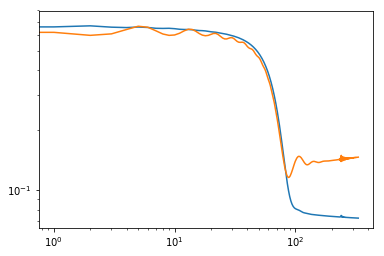

In [22]:
# Plot the learning curves: the evolution of training and validation errors during training
fig, ax = plt.subplots(1)
ax.loglog(train_errors)
ax.loglog(val_errors)

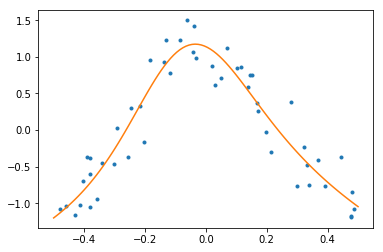

In [23]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [24]:
# Let's look at the test loss
test_loss_early_stopping = compute_loss(mlp, x_test, y_test)
print("Test loss with early stopping: %.5f" % test_loss_early_stopping)

Test loss with early stopping: 0.09190


# Weight-decay regularization

Let us train the same network with L2 penalties on the weights. In PyTorch, one can add L2 penalty terms for all the parameters by providing `weight_decay` argument for most types of optimizers.

In [25]:
# Train an MLP with L2 regularization
mlp = MLP()
mlp.to(device)
del optimizer

# Create an Adam optimizer with learning rate 0.01 and weight decay parameter 0.001
# optimizer = ...
# YOUR CODE HERE
optimizer=torch.optim.Adam(mlp.parameters(), lr=0.01,weight_decay=0.001)
#raise NotImplementedError()
n_epochs = 4000
train_errors = []
val_errors = []
for epoch in range(n_epochs):
    x = torch.tensor(x_train, device=device, dtype=torch.float)
    y = torch.tensor(y_train, device=device, dtype=torch.float)

    optimizer.zero_grad()
    outputs = mlp.forward(x)
    loss = F.mse_loss(outputs, y)
    loss.backward()
    optimizer.step()

    if (epoch % 100) == 0:
        train_errors.append(compute_loss(mlp, x_train, y_train))
        val_errors.append(compute_loss(mlp, x_test, y_test))
        print_progress(epoch, train_errors[-1], val_errors[-1])

Train Epoch 0: Train error 3.93 Validation error 3.67
Train Epoch 100: Train error 0.07 Validation error 0.10
Train Epoch 200: Train error 0.07 Validation error 0.10
Train Epoch 300: Train error 0.07 Validation error 0.10
Train Epoch 400: Train error 0.07 Validation error 0.10
Train Epoch 500: Train error 0.07 Validation error 0.10
Train Epoch 600: Train error 0.07 Validation error 0.10
Train Epoch 700: Train error 0.07 Validation error 0.10
Train Epoch 800: Train error 0.07 Validation error 0.10
Train Epoch 900: Train error 0.07 Validation error 0.10
Train Epoch 1000: Train error 0.07 Validation error 0.10
Train Epoch 1100: Train error 0.07 Validation error 0.10
Train Epoch 1200: Train error 0.07 Validation error 0.09
Train Epoch 1300: Train error 0.07 Validation error 0.10
Train Epoch 1400: Train error 0.07 Validation error 0.10
Train Epoch 1500: Train error 0.07 Validation error 0.10
Train Epoch 1600: Train error 0.07 Validation error 0.10
Train Epoch 1700: Train error 0.07 Validati

In [26]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0.001
)


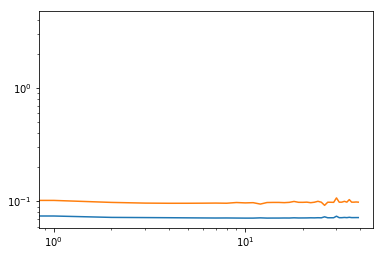

In [27]:
# Plot the learning curves (the evolution of the following quantities during training)
fig, ax = plt.subplots(1)
ax.loglog(train_errors)
ax.loglog(val_errors)

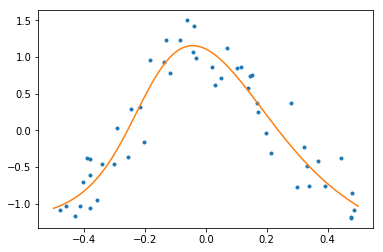

In [28]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [29]:
# Let's look at the test loss
test_loss_weight_decay = compute_loss(mlp, x_test, y_test)
print("Test loss with weight decay: %.5f" % test_loss_weight_decay)

Test loss with weight decay: 0.09963


# Injecting noise to inputs

One way to improve generalization is to add noise to the inputs. So, we update the parameters of $f$ using the gradient of the following function
$$c= \sum_{i=1}^n || f(x_i + n_i) - y_i ||^2$$
where $n_i$ is a noise instance.

In the code below, implement adding Gaussian noise with standard deviation to the given inputs.

In [30]:
def add_noise(x, noise_std):
    """Add Gaussian noise to a numpy array x.
    
    Args:
      x (array): Numpy array of inputs.
      noise_std (float): Standard deviation of the Gaussian noise.
      
    Returns:
      x with Gaussian noise added.
    """
    # YOUR CODE HERE
    noise=np.random.normal(np.zeros(x.shape[0]),noise_std)
    x=x+noise.reshape(x.shape)
    return x
    #raise NotImplementedError()

In [31]:
# Let's test shapes
x = np.random.randn(10)
x_with_noise = add_noise(x, 0.5)
assert x_with_noise.shape == x.shape, \
    "Bad shapes: x_with_noise.shape={}, x.shape={}".format(x_with_noise.shape, x.shape)

In [32]:
# Train MLP with injecting noise to inputs
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
n_epochs = 4000
train_errors = []
val_errors = []
for epoch in range(n_epochs):
    x = torch.tensor(add_noise(x_train, noise_std=0.07), device=device, dtype=torch.float)
    y = torch.tensor(y_train, device=device, dtype=torch.float)
    optimizer.zero_grad()
    outputs = mlp.forward(x)
    loss = F.mse_loss(outputs, y)
    loss.backward()
    optimizer.step()

    if (epoch % 100) == 0:
        train_errors.append(compute_loss(mlp, x_train, y_train))
        val_errors.append(compute_loss(mlp, x_test, y_test))
        print_progress(epoch, train_errors[-1], val_errors[-1])

Train Epoch 0: Train error 3.65 Validation error 3.46
Train Epoch 100: Train error 0.08 Validation error 0.09
Train Epoch 200: Train error 0.09 Validation error 0.10
Train Epoch 300: Train error 0.10 Validation error 0.13
Train Epoch 400: Train error 0.09 Validation error 0.10
Train Epoch 500: Train error 0.08 Validation error 0.11
Train Epoch 600: Train error 0.08 Validation error 0.09
Train Epoch 700: Train error 0.08 Validation error 0.10
Train Epoch 800: Train error 0.10 Validation error 0.10
Train Epoch 900: Train error 0.08 Validation error 0.09
Train Epoch 1000: Train error 0.09 Validation error 0.13
Train Epoch 1100: Train error 0.08 Validation error 0.09
Train Epoch 1200: Train error 0.09 Validation error 0.12
Train Epoch 1300: Train error 0.08 Validation error 0.10
Train Epoch 1400: Train error 0.08 Validation error 0.10
Train Epoch 1500: Train error 0.08 Validation error 0.11
Train Epoch 1600: Train error 0.08 Validation error 0.13
Train Epoch 1700: Train error 0.08 Validati

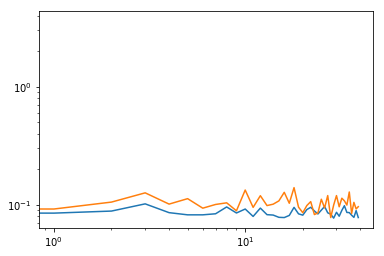

In [33]:
# Plot the learning curves: the evolution of training and validation errors during training
fig, ax = plt.subplots(1)
ax.loglog(train_errors)
ax.loglog(val_errors)

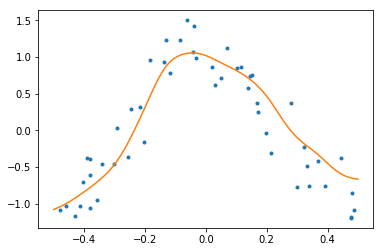

In [34]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [35]:
# Let's look at the test loss
test_loss_inj_noise = compute_loss(mlp, x_test, y_test)
print("Test loss with noise injection: %.5f" % test_loss_inj_noise)

Test loss with noise injection: 0.10515


## Dropout

Another way to improve generalization is to use dropout. In the cell below, define an MLP with exactly the same architecture as previously but with using `nn.Dropout` layers (with dropout probability 0.02) after each `tanh`
nonlinearity. 

In [36]:
class MLPDropout(nn.Module):
    def __init__(self):
        # YOUR CODE HERE
        super(MLPDropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 100),
            nn.Tanh(),
            nn.Dropout(p=0.02),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Dropout(p=0.02),
            nn.Linear(100, 1))
        #raise NotImplementedError()
        
    def forward(self, x):
        # YOUR CODE HERE
        return self.net(x)
        #raise NotImplementedError()

In [37]:
mlp = MLPDropout()
print(mlp)

MLPDropout(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.02)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.02)
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [38]:
# Train MLP with dropout
mlp = MLPDropout()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=100, gamma=0.95)
n_epochs = 4000
train_errors = []
val_errors = []
for epoch in range(n_epochs):
    scheduler.step()
    mlp.train()
    x = torch.tensor(x_train, device=device, dtype=torch.float)
    y = torch.tensor(y_train, device=device, dtype=torch.float)
    optimizer.zero_grad()
    outputs = mlp.forward(x)
    loss = F.mse_loss(outputs, y)
    loss.backward()
    optimizer.step()

    if (epoch % 100) == 0:
        mlp.eval()
        train_errors.append(compute_loss(mlp, x_train, y_train))
        val_errors.append(compute_loss(mlp, x_test, y_test))
        print_progress(epoch, train_errors[-1], val_errors[-1])

Train Epoch 0: Train error 4.85 Validation error 4.51
Train Epoch 100: Train error 0.07 Validation error 0.11
Train Epoch 200: Train error 0.07 Validation error 0.10
Train Epoch 300: Train error 0.07 Validation error 0.11
Train Epoch 400: Train error 0.07 Validation error 0.11
Train Epoch 500: Train error 0.07 Validation error 0.12
Train Epoch 600: Train error 0.07 Validation error 0.12
Train Epoch 700: Train error 0.06 Validation error 0.11
Train Epoch 800: Train error 0.06 Validation error 0.12
Train Epoch 900: Train error 0.06 Validation error 0.12
Train Epoch 1000: Train error 0.06 Validation error 0.11
Train Epoch 1100: Train error 0.06 Validation error 0.11
Train Epoch 1200: Train error 0.06 Validation error 0.10
Train Epoch 1300: Train error 0.06 Validation error 0.11
Train Epoch 1400: Train error 0.06 Validation error 0.10
Train Epoch 1500: Train error 0.06 Validation error 0.11
Train Epoch 1600: Train error 0.06 Validation error 0.11
Train Epoch 1700: Train error 0.06 Validati

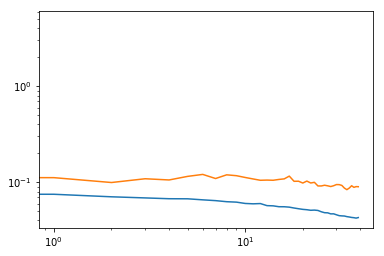

In [39]:
# Plot the learning curves (the evolution of the following quantities during training)
fig, ax = plt.subplots(1)
ax.loglog(train_errors)
ax.loglog(val_errors)

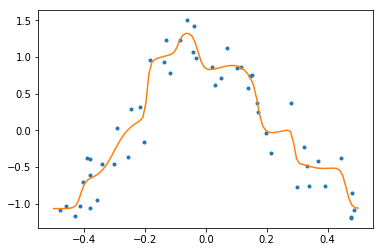

In [40]:
# Plot the final fit
mlp.eval()
plot_fit(mlp, x_train, y_train)

In [41]:
# Let's look at the test loss
test_loss_dropout = compute_loss(mlp, x_test, y_test)
print("Test loss with dropout: %.5f" % test_loss_dropout)

Test loss with dropout: 0.08493


## Regularization by reducing model capacity

Another simple way to reduce overfitting is to reduce the capacity of the model. Let us use for the same regression task a much smaller network: an MLP with one hidden layer with five units, tanh nonlinearity in the hidden layer and a linear output layer.

In [42]:
class MLPSmall(nn.Module):
    def __init__(self):
        super(MLPSmall, self).__init__()
        # YOUR CODE HERE
        super(MLPSmall, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1,5),
            nn.Tanh(),
            nn.Linear(5, 1))
        #raise NotImplementedError()
    
    def forward(self, x):
        # YOUR CODE HERE
        return self.net(x)
        #raise NotImplementedError()

In [43]:
mlp = MLPSmall()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
n_epochs = 10000
train_errors = []  # Keep track of the training data
val_errors = []  # Keep track of the validation data
for epoch in range(n_epochs):
    x = torch.tensor(x_train, device=device, dtype=torch.float)
    y = torch.tensor(y_train, device=device, dtype=torch.float)

    optimizer.zero_grad()
    outputs = mlp.forward(x)
    loss = F.mse_loss(outputs, y)
    loss.backward()
    optimizer.step()

    if (epoch % 500) == 0:
        train_errors.append(compute_loss(mlp, x_train, y_train))
        val_errors.append(compute_loss(mlp, x_val, y_val))
        print_progress(epoch, train_errors[-1], val_errors[-1])

Train Epoch 0: Train error 0.65 Validation error 0.63
Train Epoch 500: Train error 0.52 Validation error 0.51
Train Epoch 1000: Train error 0.23 Validation error 0.21
Train Epoch 1500: Train error 0.12 Validation error 0.12
Train Epoch 2000: Train error 0.09 Validation error 0.13
Train Epoch 2500: Train error 0.08 Validation error 0.14
Train Epoch 3000: Train error 0.08 Validation error 0.14
Train Epoch 3500: Train error 0.07 Validation error 0.14
Train Epoch 4000: Train error 0.07 Validation error 0.14
Train Epoch 4500: Train error 0.07 Validation error 0.14
Train Epoch 5000: Train error 0.07 Validation error 0.14
Train Epoch 5500: Train error 0.07 Validation error 0.14
Train Epoch 6000: Train error 0.07 Validation error 0.14
Train Epoch 6500: Train error 0.07 Validation error 0.15
Train Epoch 7000: Train error 0.07 Validation error 0.15
Train Epoch 7500: Train error 0.07 Validation error 0.15
Train Epoch 8000: Train error 0.07 Validation error 0.15
Train Epoch 8500: Train error 0.07 

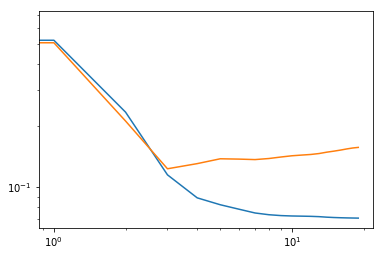

In [44]:
# Plot the learning curves (the evolution of the following quantities during training)
fig, ax = plt.subplots(1)
ax.loglog(train_errors)
ax.loglog(val_errors)

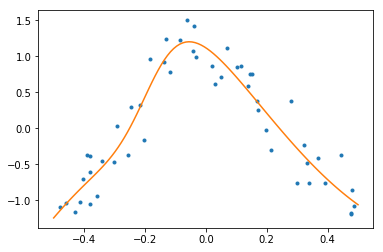

In [45]:
# Plot the final fit
mlp.eval()
plot_fit(mlp, x_train, y_train)

In [46]:
# Let's look at the test loss
test_loss_small = compute_loss(mlp, x_test, y_test)
print("Test loss with dropout: %.5f" % test_loss_small)

Test loss with dropout: 0.10096


In [47]:
# We can summarize the results obtained with different regularization methods:
print('No regularization: %.5f' % test_loss_no_regularization)
print('Early stopping:    %.5f' % test_loss_early_stopping)
print('Weight decay:      %.5f' % test_loss_weight_decay)
print('Noise injection:   %.5f' % test_loss_inj_noise)
print('Dropout:           %.5f' % test_loss_dropout)
print('Small network:     %.5f' % test_loss_small)

No regularization: 0.23199
Early stopping:    0.09190
Weight decay:      0.09963
Noise injection:   0.10515
Dropout:           0.08493
Small network:     0.10096


The values of the hyperparameters (parameters of the training procedure) may have major impact on the results. One has to find the best hyperparameter values which is usually done by measuring the performance on the validation set.